In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import time

### 读取数据文件

In [2]:
train_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),   # 随机旋转
    transforms.RandomCrop(32, padding=4),     # 放大后随机裁剪到32*32
    transforms.ToTensor(),                    # 转为tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))    # 归一化
])

test_trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
trainset = torchvision.datasets.CIFAR10(root="./data",train=True,download=True,transform=train_trans)
testset = torchvision.datasets.CIFAR10(root="./data",train=False,download=True,transform=test_trans)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

In [4]:
# 用dataloader的方式分批读取
train_loader = DataLoader(dataset=trainset, batch_size=20, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=testset, batch_size=20, shuffle=False, num_workers=0)

# gpu 加速
device = torch.device('cpu')

In [12]:
# 每个epoch的训练结果
def train_epoch(model,loop, total, epoch):
    model.train()
    running_loss = 0
    for i,(img,label) in enumerate(loop):
        img,label = img.to(device),label.to(device)    # 将数据读入gpu
        out = model(img)                               # 模型预测结果
        loss = criterion(out,label)                    # 计算损失
        optimizer.zero_grad()
        loss.backward()                                # 反向传播更新梯度
        optimizer.step()
        running_loss += loss.item() * img.size(0)
    return running_loss / total

In [13]:
def test(model,dataloader):
    model.eval()
    total = 0
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for i,(img,label) in enumerate(dataloader):
            img,label = img.to(device),label.to(device)
            out = model(img)
            loss = criterion(out, label)
            test_loss += loss.item() * img.size(0)
            _, pred = torch.max(out,1)                     # 计算正确率
            correct += (pred == label).sum().item()
            total += label.size(0)
    return test_loss / len(dataloader.dataset) ,100.0 * correct / total

In [32]:
def train(model, n_epochs):
    train_loss_arr = []
    train_acc_arr = []
    for epoch in range(n_epochs):
        loop = tqdm(train_loader)
        correct = 0
        running_loss = 0
        model.train()
        for i,(img,label) in enumerate(loop):
            img,label = img.to(device),label.to(device)    # 将数据读入gpu
            out = model(img)                               # 模型预测结果
            loss = criterion(out,label)                    # 计算损失

            optimizer.zero_grad()
            loss.backward()                                # 反向传播更新梯度
            optimizer.step()
            _, pred = torch.max(out,1)                     # 计算正确率
            correct += (pred == label).sum().item()
            running_loss += loss.item();
            loop.set_description(f'Epoch[{epoch+1}/{n_epochs}]')
            loop.set_postfix(loss = running_loss/(i+1), acc = correct/((i+1)*label.size(0)))


        train_loss, train_acc = test(model, train_loader)
        val_loss, val_acc = test(model, test_loader)
        print(f'train_loss: {train_loss}, train_acc: {train_acc}, val_loss: {val_loss}, val_acc: {val_acc}')

        train_loss_arr.append(train_loss)
        train_acc_arr.append(train_acc)
    return train_loss_arr, train_acc_arr

### MLP模型搭建

In [33]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = torch.nn.Linear(1024, 256)
        self.fc3 = torch.nn.Linear(256, 10) 
    
    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
n_epochs = 5
mlp = MLP().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=mlp.parameters(), lr=0.01, weight_decay=0.0001)
mlp_loss, mlp_acc = train(mlp, n_epochs)
print('Test Acc: {}'.format(test(mlp, test_loader)))

Epoch[1/5]: 100%|██████████| 2500/2500 [00:29<00:00, 83.97it/s, acc=0.345, loss=1.82]


train_loss: 1.6805075168132781, train_acc: 39.712, val_loss: 1.6626098792552948, val_acc: 41.65


Epoch[2/5]: 100%|██████████| 2500/2500 [00:27<00:00, 92.14it/s, acc=0.411, loss=1.64]


train_loss: 1.5891406220912934, train_acc: 43.236, val_loss: 1.5833443878889084, val_acc: 43.69


Epoch[3/5]: 100%|██████████| 2500/2500 [00:26<00:00, 92.84it/s, acc=0.441, loss=1.56]


train_loss: 1.521015192747116, train_acc: 45.432, val_loss: 1.5264491791725159, val_acc: 44.91


Epoch[4/5]: 100%|██████████| 2500/2500 [00:28<00:00, 88.34it/s, acc=0.457, loss=1.51]


train_loss: 1.472646636915207, train_acc: 47.362, val_loss: 1.49607238137722, val_acc: 46.59


Epoch[5/5]: 100%|██████████| 2500/2500 [00:28<00:00, 88.83it/s, acc=0.471, loss=1.48]


train_loss: 1.4411847297430038, train_acc: 48.7, val_loss: 1.4588250136375427, val_acc: 48.58
Test Acc: (1.4588250136375427, 48.58)


### CNN模型搭建

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)      # 6 * 28 * 28
        self.pool1 = nn.MaxPool2d(2)         # 6 * 14 * 14
        self.conv2 = nn.Conv2d(6, 16, 3)     # 16 * 12 * 12
        self.pool2 = nn.MaxPool2d(2)         # 16 * 6 * 6
        self.conv3 = nn.Conv2d(16, 64, 3)    # 64 * 4 * 4
        self.pool3 = nn.MaxPool2d(2)         # 64 * 2 * 2
        self.fc1 = nn.Linear(64 * 2 * 2 , 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2((self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [10]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=cnn.parameters(), lr=0.01, weight_decay=0.0001)
cnn_loss, cnn_acc = train(cnn, n_epochs)
print('Test Acc: {}'.format(test(cnn, test_loader)))

100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.63it/s]


Epoch 1, Train Loss 1.9916751752376556, Train Acc 35.572


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 310.53it/s]


Epoch 2, Train Loss 1.6439516931533813, Train Acc 44.784


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.74it/s]


Epoch 3, Train Loss 1.4862050265550613, Train Acc 45.424


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.86it/s]


Epoch 4, Train Loss 1.3840892729759215, Train Acc 52.468


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.43it/s]


Epoch 5, Train Loss 1.3073166884422303, Train Acc 56.034


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.16it/s]


Epoch 6, Train Loss 1.2405060944080353, Train Acc 56.762


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.76it/s]


Epoch 7, Train Loss 1.192454873085022, Train Acc 57.624


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.55it/s]


Epoch 8, Train Loss 1.1542326049685478, Train Acc 59.32


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.84it/s]


Epoch 9, Train Loss 1.1184940029501915, Train Acc 59.824


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 310.19it/s]


Epoch 10, Train Loss 1.0818753056526185, Train Acc 63.782


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.48it/s]


Epoch 11, Train Loss 1.0576249721765518, Train Acc 63.732


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.36it/s]


Epoch 12, Train Loss 1.032688270366192, Train Acc 64.042


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.48it/s]


Epoch 13, Train Loss 1.0016665070533752, Train Acc 65.422


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.93it/s]


Epoch 14, Train Loss 0.9880413618683815, Train Acc 66.934


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.93it/s]


Epoch 15, Train Loss 0.970373842549324, Train Acc 65.196


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.17it/s]


Epoch 16, Train Loss 0.9492697220802307, Train Acc 67.748


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.54it/s]


Epoch 17, Train Loss 0.9319549934506416, Train Acc 68.268


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.50it/s]


Epoch 18, Train Loss 0.9187105514705182, Train Acc 68.754


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.33it/s]


Epoch 19, Train Loss 0.9056673043131829, Train Acc 68.734


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.27it/s]


Epoch 20, Train Loss 0.8875883706450463, Train Acc 68.382


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.43it/s]


Epoch 21, Train Loss 0.88142028850317, Train Acc 69.022


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.92it/s]


Epoch 22, Train Loss 0.866758178281784, Train Acc 70.518


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.36it/s]


Epoch 23, Train Loss 0.8586498319745064, Train Acc 71.214


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.80it/s]


Epoch 24, Train Loss 0.8439140600323677, Train Acc 70.836


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.64it/s]


Epoch 25, Train Loss 0.8331722100555897, Train Acc 70.334


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.65it/s]


Epoch 26, Train Loss 0.8206579873502254, Train Acc 71.22


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.86it/s]


Epoch 27, Train Loss 0.8222532180666924, Train Acc 72.182


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.15it/s]


Epoch 28, Train Loss 0.809217429202795, Train Acc 71.792


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.93it/s]


Epoch 29, Train Loss 0.8039524889886379, Train Acc 73.23


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.62it/s]


Epoch 30, Train Loss 0.796590455776453, Train Acc 72.684


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.71it/s]


Epoch 31, Train Loss 0.7857449799716473, Train Acc 72.634


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.27it/s]


Epoch 32, Train Loss 0.7775880171120166, Train Acc 73.076


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.50it/s]


Epoch 33, Train Loss 0.77518495683074, Train Acc 71.558


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.23it/s]


Epoch 34, Train Loss 0.7633837520837784, Train Acc 73.086


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.65it/s]


Epoch 35, Train Loss 0.7605864120483399, Train Acc 73.116


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.95it/s]


Epoch 36, Train Loss 0.7525900458395481, Train Acc 74.396


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.40it/s]


Epoch 37, Train Loss 0.7452209440648556, Train Acc 74.518


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.73it/s]


Epoch 38, Train Loss 0.7348241320729255, Train Acc 72.818


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.56it/s]


Epoch 39, Train Loss 0.7310858658611774, Train Acc 74.47


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 308.05it/s]


Epoch 40, Train Loss 0.7258944186806678, Train Acc 75.732


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 309.20it/s]


Epoch 41, Train Loss 0.7228850139141083, Train Acc 74.252


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.50it/s]


Epoch 42, Train Loss 0.7157892981171607, Train Acc 75.732


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.93it/s]


Epoch 43, Train Loss 0.702448353022337, Train Acc 75.428


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 304.51it/s]


Epoch 44, Train Loss 0.7039615566194057, Train Acc 75.572


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.58it/s]


Epoch 45, Train Loss 0.6974487805783749, Train Acc 74.784


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.09it/s]


Epoch 46, Train Loss 0.6955756828784943, Train Acc 76.608


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 305.63it/s]


Epoch 47, Train Loss 0.6864923337727785, Train Acc 75.818


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.95it/s]


Epoch 48, Train Loss 0.6858986425459385, Train Acc 76.392


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 306.63it/s]


Epoch 49, Train Loss 0.6774460505485534, Train Acc 76.284


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 307.28it/s]


Epoch 50, Train Loss 0.6712483007788658, Train Acc 77.026


100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 374.38it/s]

Test Acc: 74.03


In [31]:
import matplotlib.pyplot as plt
def plot_loss_and_acc(loss_and_acc_dict):
    # visualize loss curve
    plt.figure(figsize=(12, 5))
    min_loss, max_loss = 100.0, 0.0
    for key, (loss_list, acc_list) in loss_and_acc_dict.items():
        min_loss = min(loss_list) if min(loss_list) < min_loss else min_loss
        max_loss = max(loss_list) if max(loss_list) > max_loss else max_loss
        num_epoch = len(loss_list)
        plt.plot(range(1, 1 + num_epoch), loss_list, '-s', label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(range(0, num_epoch + 1, 2))
    plt.axis([0, num_epoch + 1, min_loss - 0.1, max_loss + 0.1])
    plt.show()
    # visualize acc curve
    plt.figure(figsize=(12, 5))
    min_acc, max_acc = 100.0, 0.0
    for key, (loss_list, acc_list) in loss_and_acc_dict.items():
        min_acc = min(acc_list) if min(acc_list) < min_acc else min_acc
        max_acc = max(acc_list) if max(acc_list) > max_acc else max_acc
        num_epoch = len(acc_list)
        plt.plot(range(1, 1 + num_epoch), acc_list, '-s', label=key)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range(0, num_epoch + 1, 2))
    plt.axis([0, num_epoch + 1, min_acc, max_acc + 1])
    plt.show()

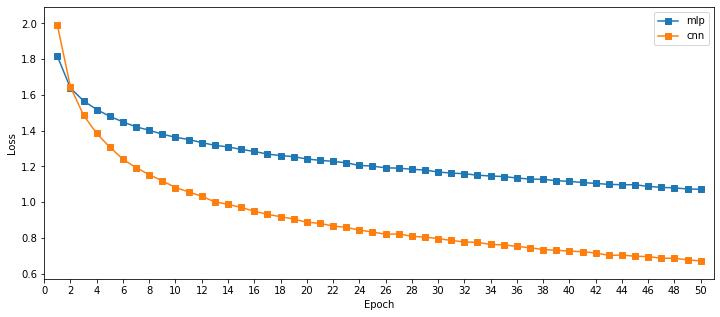

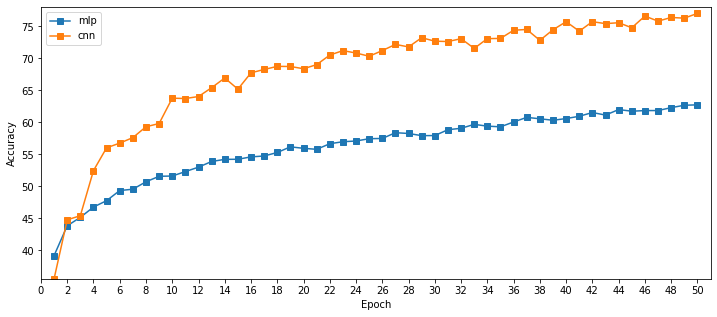

In [32]:
plot_loss_and_acc({
    "mlp": [mlp_loss, mlp_acc],
    "cnn": [cnn_loss, cnn_acc]
})

### 优化器调整

In [13]:
cnn = CNN().to(device)
optimizer = torch.optim.Adam(params=cnn.parameters(), lr=0.001)
cnn_adam_loss, cnn_adam_acc = train(cnn, n_epochs)

100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.35it/s]


Epoch 1, Train Loss 1.6284051593303681, Train Acc 47.916


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.02it/s]


Epoch 2, Train Loss 1.373994251012802, Train Acc 54.452


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.48it/s]


Epoch 3, Train Loss 1.2660846150636673, Train Acc 57.064


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.83it/s]


Epoch 4, Train Loss 1.1975943160057068, Train Acc 59.228


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 297.20it/s]


Epoch 5, Train Loss 1.1498025925278663, Train Acc 61.182


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 297.16it/s]


Epoch 6, Train Loss 1.107640919148922, Train Acc 62.78


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.30it/s]


Epoch 7, Train Loss 1.0752009946584702, Train Acc 64.586


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.53it/s]


Epoch 8, Train Loss 1.0429928255438805, Train Acc 65.15


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 304.50it/s]


Epoch 9, Train Loss 1.0238881566524505, Train Acc 65.742


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 304.05it/s]


Epoch 10, Train Loss 1.0060359440684319, Train Acc 65.212


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 304.06it/s]


Epoch 11, Train Loss 0.9796580440282822, Train Acc 65.982


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 302.85it/s]


Epoch 12, Train Loss 0.9688859931588173, Train Acc 67.35


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.04it/s]


Epoch 13, Train Loss 0.9557006212234497, Train Acc 67.014


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.28it/s]


Epoch 14, Train Loss 0.9437320191979408, Train Acc 66.122


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.57it/s]


Epoch 15, Train Loss 0.9274675722956658, Train Acc 68.08


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.16it/s]


Epoch 16, Train Loss 0.9233730497479439, Train Acc 67.876


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.96it/s]


Epoch 17, Train Loss 0.9088732523679733, Train Acc 69.564


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.89it/s]


Epoch 18, Train Loss 0.9034950937271118, Train Acc 67.938


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.34it/s]


Epoch 19, Train Loss 0.8943161262989044, Train Acc 70.588


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.71it/s]


Epoch 20, Train Loss 0.8865883742034435, Train Acc 70.052


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.60it/s]


Epoch 21, Train Loss 0.8814364163756371, Train Acc 68.978


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.62it/s]


Epoch 22, Train Loss 0.8720326276659965, Train Acc 69.748


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.09it/s]


Epoch 23, Train Loss 0.8700879257440567, Train Acc 70.572


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.11it/s]


Epoch 24, Train Loss 0.8624120341598988, Train Acc 71.184


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.58it/s]


Epoch 25, Train Loss 0.8516215699493885, Train Acc 71.472


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.01it/s]


Epoch 26, Train Loss 0.8573283475905656, Train Acc 69.938


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.97it/s]


Epoch 27, Train Loss 0.8423659414768219, Train Acc 71.752


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.90it/s]


Epoch 28, Train Loss 0.8438741432785988, Train Acc 70.218


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.15it/s]


Epoch 29, Train Loss 0.8259014063537121, Train Acc 72.146


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 300.89it/s]


Epoch 30, Train Loss 0.8357456741213799, Train Acc 71.474


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 300.22it/s]


Epoch 31, Train Loss 0.8249867440760136, Train Acc 72.762


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.01it/s]


Epoch 32, Train Loss 0.8246908320188522, Train Acc 71.754


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.61it/s]


Epoch 33, Train Loss 0.8234181012392044, Train Acc 72.49


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.22it/s]


Epoch 34, Train Loss 0.8113491651654243, Train Acc 72.56


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.70it/s]


Epoch 35, Train Loss 0.8050242069721222, Train Acc 72.782


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 300.34it/s]


Epoch 36, Train Loss 0.8048526182234287, Train Acc 72.678


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.79it/s]


Epoch 37, Train Loss 0.80424421210289, Train Acc 73.834


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.63it/s]


Epoch 38, Train Loss 0.8003241859793663, Train Acc 73.002


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.97it/s]


Epoch 39, Train Loss 0.7952657524108887, Train Acc 73.066


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 300.49it/s]


Epoch 40, Train Loss 0.7950558718293905, Train Acc 73.958


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.63it/s]


Epoch 41, Train Loss 0.7928394308149814, Train Acc 73.454


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.57it/s]


Epoch 42, Train Loss 0.7923310320198536, Train Acc 72.548


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.29it/s]


Epoch 43, Train Loss 0.7874132122278213, Train Acc 74.516


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.61it/s]


Epoch 44, Train Loss 0.7822324829101562, Train Acc 73.638


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.20it/s]


Epoch 45, Train Loss 0.7797397720217705, Train Acc 74.246


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.92it/s]


Epoch 46, Train Loss 0.7755527849555015, Train Acc 73.706


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.00it/s]


Epoch 47, Train Loss 0.7687217115104198, Train Acc 74.556


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.77it/s]


Epoch 48, Train Loss 0.7755873042285443, Train Acc 73.206


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 298.59it/s]


Epoch 49, Train Loss 0.7645300450325012, Train Acc 73.874


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 299.41it/s]

Epoch 50, Train Loss 0.7688073013603687, Train Acc 73.496


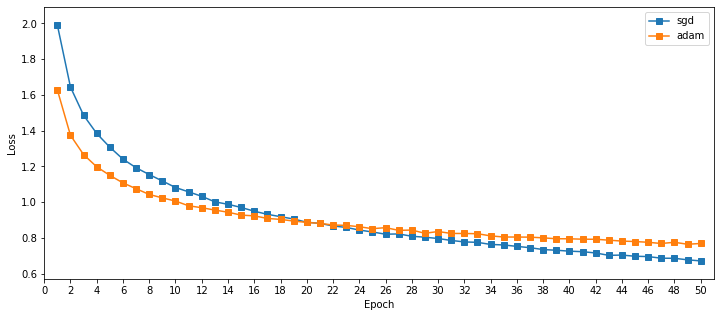

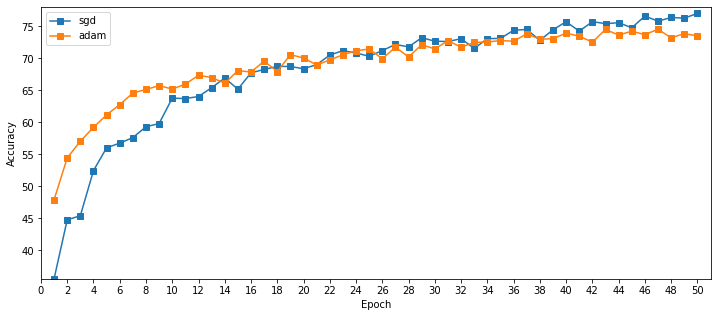

In [33]:
plot_loss_and_acc({
    "sgd": [cnn_loss, cnn_acc],
    "adam": [cnn_adam_loss, cnn_adam_acc]
})

### 增加模型层数

In [15]:
class CNNNew(nn.Module):
    def __init__(self):
        super(CNNNew, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)      # 6 * 28 * 28
        self.pool1 = nn.MaxPool2d(2)         # 6 * 14 * 14
        self.conv2 = nn.Conv2d(6, 16, 3)     # 16 * 12 * 12
        self.pool2 = nn.MaxPool2d(2)         # 16 * 6 * 6
        self.conv3 = nn.Conv2d(16, 64, 3)    # 64 * 4 * 4
        self.pool3 = nn.MaxPool2d(2)         # 64 * 2 * 2
        self.fc1 = nn.Linear(64 * 2 * 2 , 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 10)
        
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2((self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, 0.3)                # 增加dropout层
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
        

In [16]:
cnn = CNNNew().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=cnn.parameters(), lr=0.01, weight_decay=0.0001)
cnn_new_loss, cnn_new_acc = train(cnn, n_epochs)
print('Test Acc: {}'.format(test(cnn, test_loader)))

100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.00it/s]


Epoch 1, Train Loss 2.061218046474457, Train Acc 32.388


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.55it/s]


Epoch 2, Train Loss 1.6921974448680879, Train Acc 41.474


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.84it/s]


Epoch 3, Train Loss 1.524763755941391, Train Acc 47.206


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.59it/s]


Epoch 4, Train Loss 1.4182450795173644, Train Acc 49.402


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.64it/s]


Epoch 5, Train Loss 1.3457286971092224, Train Acc 53.376


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 241.57it/s]


Epoch 6, Train Loss 1.2824912640094757, Train Acc 56.474


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.10it/s]


Epoch 7, Train Loss 1.2274520064353942, Train Acc 58.464


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.68it/s]


Epoch 8, Train Loss 1.1875152799606323, Train Acc 57.978


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 238.21it/s]


Epoch 9, Train Loss 1.1473888678073882, Train Acc 60.152


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.13it/s]


Epoch 10, Train Loss 1.1173388466238976, Train Acc 59.884


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.23it/s]


Epoch 11, Train Loss 1.0862874094843864, Train Acc 62.7


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.87it/s]


Epoch 12, Train Loss 1.0604550121188163, Train Acc 62.984


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.62it/s]


Epoch 13, Train Loss 1.0357058205723761, Train Acc 63.796


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.99it/s]


Epoch 14, Train Loss 1.0082539036750793, Train Acc 65.436


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.14it/s]


Epoch 15, Train Loss 0.992057300722599, Train Acc 66.204


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.87it/s]


Epoch 16, Train Loss 0.9693211829543114, Train Acc 65.844


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.93it/s]


Epoch 17, Train Loss 0.951140228664875, Train Acc 67.354


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.93it/s]


Epoch 18, Train Loss 0.9368535845518112, Train Acc 67.328


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.83it/s]


Epoch 19, Train Loss 0.9176787162542344, Train Acc 67.992


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.47it/s]


Epoch 20, Train Loss 0.9039349716305732, Train Acc 67.128


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.50it/s]


Epoch 21, Train Loss 0.8901331462025642, Train Acc 68.202


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.47it/s]


Epoch 22, Train Loss 0.876839220237732, Train Acc 70.126


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.28it/s]


Epoch 23, Train Loss 0.873547902739048, Train Acc 70.628


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.88it/s]


Epoch 24, Train Loss 0.8627936824083329, Train Acc 70.28


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.07it/s]


Epoch 25, Train Loss 0.854868869382143, Train Acc 71.28


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.53it/s]


Epoch 26, Train Loss 0.8361197281062603, Train Acc 71.52


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 243.61it/s]


Epoch 27, Train Loss 0.8284366745710373, Train Acc 71.28


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.91it/s]


Epoch 28, Train Loss 0.8203815553724766, Train Acc 72.066


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.49it/s]


Epoch 29, Train Loss 0.8091612487792968, Train Acc 72.316


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.06it/s]


Epoch 30, Train Loss 0.799300690639019, Train Acc 71.89


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.15it/s]


Epoch 31, Train Loss 0.7956077742397785, Train Acc 72.328


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.58it/s]


Epoch 32, Train Loss 0.7882019246697426, Train Acc 72.942


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.62it/s]


Epoch 33, Train Loss 0.7768315303266048, Train Acc 73.828


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 243.60it/s]


Epoch 34, Train Loss 0.7715563405215741, Train Acc 73.196


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 246.99it/s]


Epoch 35, Train Loss 0.7687709989726543, Train Acc 73.476


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.89it/s]


Epoch 36, Train Loss 0.7573051664173603, Train Acc 73.606


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.02it/s]


Epoch 37, Train Loss 0.7535816008985042, Train Acc 73.65


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.46it/s]


Epoch 38, Train Loss 0.7443898680895566, Train Acc 75.202


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.31it/s]


Epoch 39, Train Loss 0.734904486989975, Train Acc 74.544


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.44it/s]


Epoch 40, Train Loss 0.7309228350937367, Train Acc 75.104


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.64it/s]


Epoch 41, Train Loss 0.7219025570511818, Train Acc 75.266


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.51it/s]


Epoch 42, Train Loss 0.7232393014073372, Train Acc 75.54


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.18it/s]


Epoch 43, Train Loss 0.7144381363093854, Train Acc 75.38


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 243.68it/s]


Epoch 44, Train Loss 0.7100751404941082, Train Acc 75.366


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 245.54it/s]


Epoch 45, Train Loss 0.701216703426838, Train Acc 76.244


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.89it/s]


Epoch 46, Train Loss 0.7001410441577435, Train Acc 76.484


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 242.28it/s]


Epoch 47, Train Loss 0.6994458618760109, Train Acc 76.078


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.79it/s]


Epoch 48, Train Loss 0.689634951877594, Train Acc 76.008


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 244.78it/s]


Epoch 49, Train Loss 0.6798847847402095, Train Acc 76.496


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:10<00:00, 243.20it/s]


Epoch 50, Train Loss 0.6801970268666744, Train Acc 75.998


100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 283.65it/s]

Test Acc: 73.13


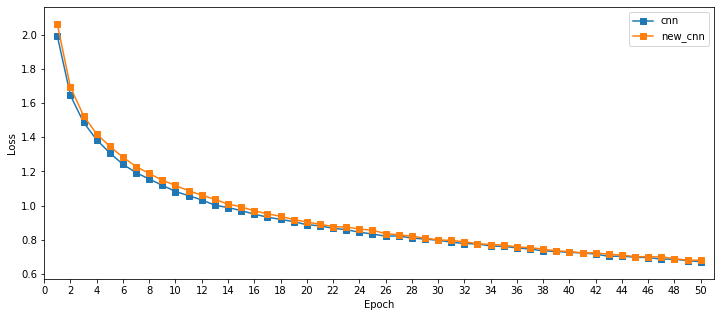

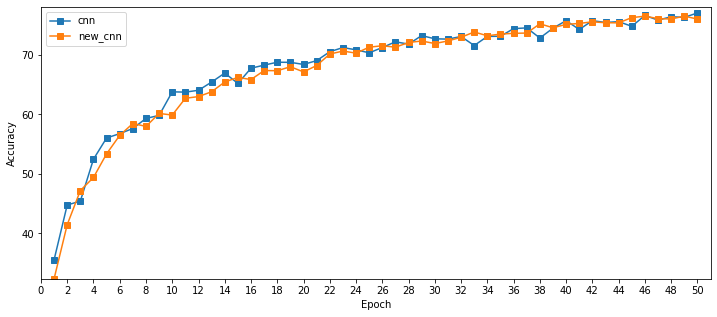

In [34]:
plot_loss_and_acc({
    "cnn": [cnn_loss, cnn_acc],
    "new_cnn": [cnn_new_loss, cnn_new_acc]
})

### 修改激活函数

In [18]:
class CNNTanh(nn.Module):
    def __init__(self):
        super(CNNTanh, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)      # 6 * 28 * 28
        self.pool1 = nn.MaxPool2d(2)         # 6 * 14 * 14
        self.conv2 = nn.Conv2d(6, 16, 3)     # 16 * 12 * 12
        self.pool2 = nn.MaxPool2d(2)         # 16 * 6 * 6
        self.conv3 = nn.Conv2d(16, 64, 3)    # 64 * 4 * 4
        self.pool3 = nn.MaxPool2d(2)         # 64 * 2 * 2
        self.fc1 = nn.Linear(64 * 2 * 2 , 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)
        
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2((self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
cnn = CNNTanh().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(params=cnn.parameters(), lr=0.01, weight_decay=0.0001)
cnn_tanh_loss, cnn_tanh_acc = train(cnn, n_epochs)
print('Test Acc: {}'.format(test(cnn, test_loader)))

  0%|                                                                                                   | 0/2500 [00:00<?, ?it/s]/Users/chaoxiong.yang/opt/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.91it/s]


Epoch 1, Train Loss 1.8940193250179291, Train Acc 38.048


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.59it/s]


Epoch 2, Train Loss 1.5809888205051421, Train Acc 46.18


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.65it/s]


Epoch 3, Train Loss 1.4430088344573975, Train Acc 47.268


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.45it/s]


Epoch 4, Train Loss 1.3624686031579971, Train Acc 53.378


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.61it/s]


Epoch 5, Train Loss 1.3015382622718812, Train Acc 54.688


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.46it/s]


Epoch 6, Train Loss 1.2518941329956055, Train Acc 55.82


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 278.98it/s]


Epoch 7, Train Loss 1.2137986455202103, Train Acc 58.702


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.32it/s]


Epoch 8, Train Loss 1.1730347820997238, Train Acc 59.678


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 278.94it/s]


Epoch 9, Train Loss 1.1446776666045189, Train Acc 60.866


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.34it/s]


Epoch 10, Train Loss 1.1160673596024513, Train Acc 61.064


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 277.67it/s]


Epoch 11, Train Loss 1.0927383121967316, Train Acc 62.728


100%|████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:52<00:00,  8.56it/s]


Epoch 12, Train Loss 1.0683541803002357, Train Acc 63.352


100%|████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [17:18<00:00,  2.41it/s]


Epoch 13, Train Loss 1.0491547041416167, Train Acc 63.586


100%|████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [04:52<00:00,  8.56it/s]


Epoch 14, Train Loss 1.0289390483021736, Train Acc 64.772


100%|████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [32:29<00:00,  1.28it/s]


Epoch 15, Train Loss 1.0107403963327408, Train Acc 64.75


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.21it/s]


Epoch 16, Train Loss 0.9936333428740501, Train Acc 65.39


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 283.13it/s]


Epoch 17, Train Loss 0.9812335860967636, Train Acc 64.008


100%|████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [31:17<00:00,  1.33it/s]


Epoch 18, Train Loss 0.9726942037582398, Train Acc 66.322


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.60it/s]


Epoch 19, Train Loss 0.9540198825240135, Train Acc 66.76


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.19it/s]


Epoch 20, Train Loss 0.9414076326370239, Train Acc 67.034


100%|████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [34:22<00:00,  1.21it/s]


Epoch 21, Train Loss 0.9310443467378616, Train Acc 68.45


100%|████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [33:49<00:00,  1.23it/s]


Epoch 22, Train Loss 0.9167476553618908, Train Acc 67.988


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 272.14it/s]


Epoch 23, Train Loss 0.9096610788941384, Train Acc 68.032


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 278.74it/s]


Epoch 24, Train Loss 0.9004341019511223, Train Acc 69.128


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.04it/s]


Epoch 25, Train Loss 0.8896930924654007, Train Acc 69.254


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.82it/s]


Epoch 26, Train Loss 0.8840834145367146, Train Acc 68.532


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 283.47it/s]


Epoch 27, Train Loss 0.876722139185667, Train Acc 69.764


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.67it/s]


Epoch 28, Train Loss 0.8638304978966713, Train Acc 70.59


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.37it/s]


Epoch 29, Train Loss 0.8555133775472641, Train Acc 69.486


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.81it/s]


Epoch 30, Train Loss 0.8523251500189304, Train Acc 70.368


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.95it/s]


Epoch 31, Train Loss 0.8423602435052395, Train Acc 71.042


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.25it/s]


Epoch 32, Train Loss 0.8374500853419304, Train Acc 71.208


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.42it/s]


Epoch 33, Train Loss 0.8331082593798638, Train Acc 71.324


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.21it/s]


Epoch 34, Train Loss 0.8235525925934315, Train Acc 72.008


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.05it/s]


Epoch 35, Train Loss 0.8166277218937874, Train Acc 71.872


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.01it/s]


Epoch 36, Train Loss 0.8084904895961285, Train Acc 71.572


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 282.17it/s]


Epoch 37, Train Loss 0.8087896985292434, Train Acc 72.322


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.18it/s]


Epoch 38, Train Loss 0.8006245952785015, Train Acc 72.252


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.00it/s]


Epoch 39, Train Loss 0.8006220763325691, Train Acc 72.708


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.61it/s]


Epoch 40, Train Loss 0.7923751194417477, Train Acc 72.894


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.91it/s]


Epoch 41, Train Loss 0.7870010082483292, Train Acc 73.212


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 279.73it/s]


Epoch 42, Train Loss 0.7819677932024002, Train Acc 73.312


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.07it/s]


Epoch 43, Train Loss 0.7764471396446228, Train Acc 73.93


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.64it/s]


Epoch 44, Train Loss 0.7729852872550488, Train Acc 73.068


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 281.73it/s]


Epoch 45, Train Loss 0.7638076986074448, Train Acc 72.15


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 278.78it/s]


Epoch 46, Train Loss 0.7603028479337692, Train Acc 74.088


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.95it/s]


Epoch 47, Train Loss 0.7535213288545608, Train Acc 73.692


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 273.49it/s]


Epoch 48, Train Loss 0.758334881991148, Train Acc 71.85


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.71it/s]


Epoch 49, Train Loss 0.7560197077989578, Train Acc 74.762


100%|███████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:08<00:00, 280.30it/s]


Epoch 50, Train Loss 0.7479605409920216, Train Acc 74.364


100%|█████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 337.27it/s]

Test Acc: 73.51


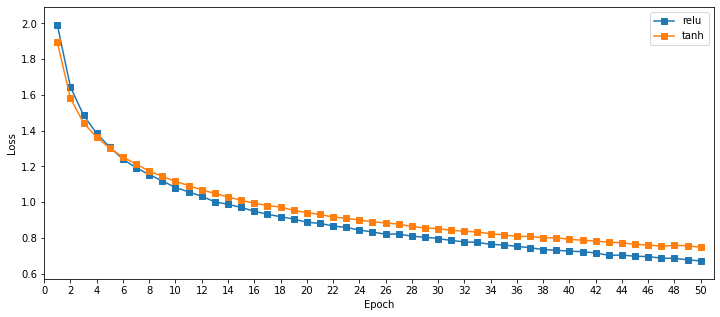

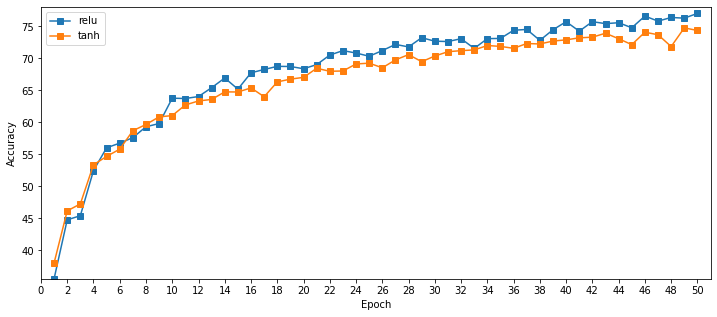

In [35]:
plot_loss_and_acc({
    "relu": [cnn_loss, cnn_acc],
    "tanh": [cnn_tanh_loss, cnn_tanh_acc]
})   